In [1]:
import re
import os
import numpy as np
import pandas as pd
import pickle as pkl
import os.path as path
from tqdm.notebook import tqdm, trange

from sklearn.model_selection import train_test_split

In [2]:
data_home = "/dgxhome/cra5302/Disclosure/SelfDisclosure/dataset/twitter"
labeled = path.join(data_home, "labeled/Gold_Standard.xlsx")
unlabeled = path.join(data_home, "unlabeled")

In [3]:
data_files = [path.join(unlabeled, file) for file in os.listdir(unlabeled)]

In [4]:
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tweet = tweet.lower()
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    
    return " ".join(normTweet.split())

In [ ]:
compile_data = {"ID" : None,
                "Text" : None
#                 ,"BTText": None
               }

TweetIDs = []
Tweets = []
Raw_Tweets = []

for file in tqdm(data_files):
    with open(file, "rb") as handle:
        try:
            data_instance = pkl.load(handle)
        except:
            continue
        # sample maximum of 1000 tweets from this instance
        if len(data_instance) > 1000:
            data_instance = data_instance.sample(1000)
        
        # # for loop is too slow
        # for index, row in tqdm(data_instance.iterrows(), leave=False):
        #     TweetIDs.append(row["TweetID"])
        #     Tweets.append(clean_tweet(row["Tweet"]))
        
        instance_ids = data_instance["TweetID"].to_list()
        instance_tweets = list(np.vectorize(normalizeTweet)(data_instance["Tweet"]))
        instance_raw_tweets = data_instance["Tweet"].to_list()
        
        TweetIDs.extend(instance_ids)
        Tweets.extend(instance_tweets)
        Raw_Tweets.extend(instance_raw_tweets)

compile_data["ID"] = TweetIDs
compile_data["Text"] = Tweets
compile_data["Raw_Tweet"] = Raw_Tweets

unlabeled_df = pd.DataFrame(compile_data)
unlabeled_df.dropna(axis=0)
unlabeled_df = unlabeled_df[unlabeled_df["Text"] != '']
unlabeled_df.to_csv(path.join(data_home, "unlabeled_data.csv"))

In [6]:
train_df = pd.read_excel(labeled)

# for consistency with unlabeled data
train_df["ID"] = train_df["TWEETID"].to_list()
train_df["Text"] = list(np.vectorize(normalizeTweet)(train_df["Raw_Tweet"]))

train_df, test_df = train_test_split(train_df, test_size=0.20, random_state=47)

train_df.to_csv(path.join(data_home, "labeled_data.csv"))
test_df.to_csv(path.join(data_home, "test_data.csv"))

In [7]:
print ("Number of labeled tweets", train_df.shape[0] + test_df.shape[0])
print ("Number of unlabeled tweets", unlabeled_df.shape[0])
# print ("Number of unique users", len(users))

Number of labeled tweets 5000


NameError: name 'unlabeled_df' is not defined

In [10]:
# with open(path.join(data_home, "users.npy"), "wb") as handle:
#     np.save(handle, users)

### Checking sentences

In [11]:
for file in tqdm(data_files):
    with open(file, "rb") as handle:
        try:
            data_instance = pkl.load(handle)
        except:
            continue
        # sample maximum of 1000 tweets from this instance
        if len(data_instance) > 1000:
            data_instance = data_instance.sample(1000)
        
        for index, row in tqdm(data_instance.iterrows(), leave=False):
            r = re.findall("\.", row["Tweet"])
            if len(r) == 1:
                print (row["Tweet"])
            break

RT @bluedgal: @Mikel_Jollett @American4Love He won’t wear a mask.


RT @AdamBlickstein: Bold new coronavirus messaging from the Trump White House https://t.co/Uh9kS66kLW


RT @jonfavs: The office where the President works requires masks, conducts frequent testing, and does contact tracing. 

Trump and his staf…


RT @trending_medic: The Catholic Church has donated ALL its 425 hospitals as COVID-19 isolation centers.

When you see a good thing please…


RT @Channel4News: This man has chosen to be human guinea pig for a coronavirus vaccine

https://t.co/KhpGIHBvb2


"Despite intensive effort, the traveler screening system did not effectively prevent introduction of COVID-19 into California."


@wanderlusting81 Kevin Bain is not mad about Covid, he's mad about being a loser.


RT @JennaEllisEsq: So @jack this means you’re suspending @WHO and all China spox, right? https://t.co/a4bz6Y1D5y


Wow, @JimPethokoukis incessant Quibi watching - on multiple screens! - has not sufficed.


RT @peterjukes: More on the anathema of herd immunity without a vaccine. But two months ago our Head of the Nudge Unit, Chief Scientific Of…


@dbongino That means everyone in the US, except Washington State, gets to call this the New York City virus since t… https://t.co/7utHNPCMCE


@JANUSZCZAK When they make the Covid 19 disaster movie, which I am sure they will in 10 years time, Matt Lucas with… https://t.co/iEDkU3hB56


RT @nowthisnews: This social distancing blanket helps picnickers get together safely https://t.co/0ztzQKyWJ3


5 Digital Health #Technologies Helping to Stop the COVID-19 #Pandemic
https://t.co/0TKTZHMMJL


RT @frankiemacd: Here is me Saying COVID-19 Vaccine https://t.co/kBBTyrTRCf


RT @Malcolmvelli: John Cena wrote “My Time is Now” in 4 hours.


RT @colgrove11: Trump tells nearly every reporter to look into the origins of the COVID19.

Yet 1 American reporter asks about why Trump pr…


RT @obisingledigit: No theatrics, no vibes, no 5G, no "miracles", just action.


RT @DonaldJTrumpJr: This times 1000! https://t.co/ToMZf6vbGj


RT @thecableng: Catholic Church donates ALL its 425 hospitals in Nigeria as COVID-19 isolation centres | TheCable https://t.co/l2NNCqTIrc…


RT @REFORM: We spoke with more than 20 people about what they’re looking forward to when this pandemic is all over. Turns out, we all want…


Y'all know how much I love Babs and Orange but if this hit they would've taken it all I truly feel bad the year the… https://t.co/279GiukQQv


RT @RealMadDadMAGA: NURSE says. Take off Your Mask!!!
ZERO protection from viruses
#ObaMAGAte 
#hoaxvirus #COVID #OPENAMERICANOW #MAGA Get…


@TrollbotN @RepDanCrenshaw What "warriors" are on the front lines without tests? It isn't hard to find a drive up t… https://t.co/0C3aCeaorE


RT @harrisonjaime: A reminder that before the coronavirus outbreak, Lindsey Graham promised to take away your health care. Remember that in…


@veryheathmiller I agree with those saying "Monday" but what I don't get is-- we work from home all the time, we're… https://t.co/LIMA1nClP1


RT @justinjm1: Elon Musk was cavalier about worker safety long before coronavirus https://t.co/8IIHTDGUpV


RT @_PSalad: This is the same woman that came out on the day of a Mosque shooting in her country and showed support to every Muslim. Weeks…


RT @mrmanheree: This lockdown has everyone discovering their inner talents 😂

 https://t.co/kuXsvVuL65


RT @SaraCarterDC: China's State-Run Media Claims 'Data Revision' Of #COVID Numbers Is 'Common International Practice' 

https://t.co/LPa8PA…


RT @maddow: "Multiple White House Staffers Diagnosed With COVID-19 as Trump, Pence Hold Photo-Ops With the Elderly"
https://t.co/RIHZ4II2Xz


Has anyone even thought of why he thinks he's not vulnerable? What were those PATENTS Ivanka obtained from CHINA? A… https://t.co/fH5EBTugQU


Alarm bells sound over historic deficit spending, as coronavirus bills could near $5T

https://t.co/PyRSpyWsty
Spend Spend Spend !!!!
Both Sides suck!


RT @harrisonjaime: A reminder that before the coronavirus outbreak, Lindsey Graham promised to take away your health care. Remember that in…


RT @drdavidallen: More emerging evidence supporting universal mask wearing. @patientsafe3 @DrWilliams @CatPurry9 #COVID19Aus #MedTwitter #a…


RT @OneTrickTofani: Protesting my local GameStop to reopen by playing the games I already own in front of it https://t.co/jtqtAtes8s


RT @riseupmelbourne: Funny how we haven't seen any COVID19 news out of our old friend Russia. I'll throw one statistic that should tell you…


@wuranicole @quadri_tosi I advise you damn coronavirus and go see her. Don't stop to and do it soonest! 😒😊


Once you bring the sport back there is some level of responsibility that the athlete has to be held to for the heir… https://t.co/k7AHZveA5L


@Kike_manBTC @pockbinh Have you ever wondered 🤔 🤔 why some people keep wishing that this lockdown continues so that… https://t.co/AtRXr7jTFJ


@ginamei killed it with this, and there’s so much more to come! Stay tuned for wild, delightful tales of polyamory,… https://t.co/Z3IXUCZQ9w


Australian researchers trace sewage for early warning COVID-19 spread https://t.co/JBypQQ6dqK via @uq_news


RT @trending_medic: The Catholic Church has donated ALL its 425 hospitals as COVID-19 isolation centers.

When you see a good thing please…


RT @Tutsy22: A 60-year-old US citizen suspected to have shown symptoms of #COVID19 has died in Delta state.


RT @TomiLahren: 2,300 “social distancing ambassadors?” Are you freakin kidding, @NYCMayor ???! The tyranny continues.


RT @CNBC: Another study shows drug touted by Trump doesn't help coronavirus patients, but it can contribute to heart attacks https://t.co/w…


How many lives would be saved if we were able to predict #COVID19 a week earlier? Or even a month? In the growing f… https://t.co/d2TMpCrp6n


RT @GovKaduna: KADUNA UPDATE: 13 more Covid-19 cases have been recorded in the state. 

There are 92 active cases and four fatalities from…


Coronavirus Daily for Monday:
⚫️More than 80,000 Americans have died from COVID-19
⚫️President Trump says US has "p… https://t.co/SQ9tW9EJqv


RT @IrishTimes: 103-year-old Dublin woman survives Covid-19 and looks for her lipstick https://t.co/hHWrg4ox6N


RT @kmbfor42: It is important to note my plan was written and proposed before the pandemic. We need legislators that focus on creating reve…


RT @dril: its apparent people arent taking these social distancing measures seriously. on my way to the gym i had 2 people suck my shit com…


BREAKING: Kano extends lockdown by one week.


RT @KoreanAir_KE: In order to prevent the spread of COVID-19, Korean Air is following all announced government measures. We have organized…


AP Exams Begin Despite Coronavirus School Closures : Coronavirus Live Updates : NPR https://t.co/az967swLRG


RT @realDonaldTrump: Great credit being given for our Coronavirus response, except in the Fake News. They are a disgrace to America!


@Bbest_hypocrite I'm not a Republican but it only proves my point of the other post that everything you say is to p… https://t.co/a9HQgWt9bY


@petelivingstone @christymaginn @muldervinscully @SolomonMarlow @NateSilver538 Yo! What will be of our society? Our… https://t.co/Xud9WO2wHR


Did you hear? Oscar’s Medicare Advantage members get increased access to government programs that provide financial… https://t.co/isFY7vXtNn


RT @realDonaldTrump: Great credit being given for our Coronavirus response, except in the Fake News. They are a disgrace to America!


This petition is now at 32,914 signatures it needs many more,if you feel this government has been incompetent over… https://t.co/hlF84sLcKb


RT @stengel: We remain a disaster on the three T's of the pandemic: testing, tracking, and tracing. But the reason for that is the fourth T…


RT @aravosis: Trump storms out of coronavirus press conference after getting called out for a racist comment to an Asian American reporter.…


@denver_mccomb He is definitely responsible for the Nursing home deaths which happened because of his edict to move… https://t.co/gNcsfBJeDd


So Chinese Virus was racist but European Virus isn't?

What in the absolute fuck are these politicians doing?!

Dam… https://t.co/W3O4fdLbJu


@va_shiva I want to ask u about the job in NJ of being a coronavirus contact tracer. Legit or something behind the scenes?


RT @shomaristone: White House to require staffers to wear masks in West Wing.
The president painted an improving picture of the coronavirus…


RT @tolusomolu: Absolutely no surprises.


RT @scorsaguin: after 2 months of community quarantine: https://t.co/bAbSnNvhla


@LaRosasPizza  it seems the people in your Wyoming store aren't worried about the coronavirus as they wear all of t… https://t.co/BxONx4Wfjf


Tbh I don’t really care about corona because I play video games all day. But I’m not really the vibe the fact I can’t go out and have sushi and plum wine


With the proliferation of covid 19 infections in Nigeria, it's imperative we seriously begin to invest in capacity for increased testing.


I watched a 2011 movie today "Contagion" and immediately could spot how detailed the prediction for such a pandemic we are having today was carefully scripted and acted. Wow!


Why a Second Wave of Covid-19 Is Already a Worry https://t.co/227BKRnxVJ


French Doctors say treatment against coronavirus should be tested in Africa https://t.co/twr2AFUn1w via @MailOnline


#StayHome to 👊 #COVID19 &amp; watch ckt videos

Watch stylish Zaheer Abbas' 176 destroying Ind bowling in 1978 #indvpak

 #TeamIndia #cricket #IPL #bcci 
#IPLT20  
@chetans1987
@iNaseemShah
 @azharflicks
@cricketwallah
@vikrantgupta73
@ZAbbasOfficial 
@ImranKhanPTI 
 @BoriaMajumdar https://t.co/HMaZPT5XzE


You're not social distancing boys, u know that right? https://t.co/aWzsCwV4Qn


‘It was very distressing': Couple share ordeal of giving birth under coronavirus restrictions | Sign up to @indypremium to read https://t.co/Co7A2KCevy


Access Code #distancelearning #StayHome https://t.co/jQ6sKigGxR


On a #Coronavirus Cruise, a Knock on the Door: 'You Tested Positive' https://t.co/mJvcTZaRxl


#Tokyo #japan #digitalart about the escape from the #coronavírus #epidemic in #China https://t.co/1ct6quM3zI


CHINA GRINDS TO A HALT: "BLACK SWAN" EVENT WORST-CASE SCENARIO https://t.co/30AIxoWzNA via @YouTube


Chinese Scientists Believe Coronavirus Came From Virology Lab In Wuhan https://t.co/Gvvutn8erU


Levi's Shuts Half Its China Stores on Coronavirus Outbreak https://t.co/U84SCpLgCA via @BoF


"A state-run platform called 'close contact detector' now allows employers to check if their workers have been in close contact with confirmed or suspected coronavirus patients in the past 14 days by inputting the employees’ national ID numbers."


@genUltra @CanipaShow depends on where you are getting the news

in general, the COVID-19 is most dangerous to people with weakened immune systems (particularly the elderly).

If you are healthy, young and do the most basics of hygiene &amp; don't inhale other plp's spit, you are fine


Coronavirus Live Updates: Foreigners Urged to Take Advantage of Possible Last Flights

https://t.co/T2DxCCSBjD


Mom who jumped to her death in China left passwords to access suicide note on phone 
#mom #suicide #china #death #password #usnews #Depression #trending 
https://t.co/YS6sRyHnLY


20 local module hospitals in other parts of China and 600 medical staff will arrive in Wuhan from today to work in the three hospitals; over 1,400 nurses from across China will go to Wuhan.


#UEFA are worried the #cornovirus might take their spot as the leading epidemic in Europe.


Blocking all Chinese travelers? Wow! #Philippines' Bureau of Immigration says it will temporarily stop issuing tourist visas on arrival to Chinese nationals to help ensure the country stays free of the #coronavirus.


Coronavirus misinformation grips Internet and social media; How to identify them?

#CoronavirusOutbreak #CoronaOutbreak 
https://t.co/JmsWWjaMO9


Get Over It! China is already recovering, mainly old-timers are in any danger, says RT commentator  https://t.co/MNRP10FbUF


Coronavirus could force ISPs to abandon data caps forever https://t.co/duJfzz2THA


Corona got us like Pablo https://t.co/rerQ3pV5Sb


@realDonaldTrump Why did you call the coronavirus virus a hoax at your rally?  Why?   You should be kicked out of office for a stunt like that.


@0kaits bro i got my tests back today and i tested negative for corona ): might be fucked https://t.co/RIkuDIFMMP


@CNNPolitics He's trying to cut Medicaid during a pandemic.


Rats swarm New Orleans' streets as coronavirus precautions leave them empty - CBS News https://t.co/ugkbvxj5I7 via @GoogleNews


Drone Delivery By Geely: Selling Cars In The Age Of COVID-19 https://t.co/PV0z3RrS4m #TeamElon $TSLA #Tesla


@telegraph_sport @MitchJohnson398 @benstokes38 Root and co acting like they are going to some third world country so no touching people but fact is UK has more coronavirus cases than Srilanka.


Hi, New post on my website: Americans’ Demands for Coronavirus Tests Grow as Cases Spread by BY KATIE THOMAS, SARAH KLIFF AND NICHOLAS BOGEL-BURROUGHS https://t.co/CMWcgna5ll Bye


@davidosoriodos @CNBC No. it should be more expensive now as separate rooms in flight would be on high demand due to Corona virus


Hackers Target Companies With Coronavirus Scams, find out more on The Wall Street Journal https://t.co/d29b5XoWCX



In [12]:
data_instance.columns

Index(['TweetID', 'TimeStamp', 'Tweet_Type', 'UserID', 'Name', 'Screen_Name',
       'Verified', 'ParentID', 'ParentUID', 'Tweet', 'Added_Text',
       'RT_QT_Text', '#Retweeted', '#Quoted', '#Favorited', '#Followers',
       '#Following', 'HashTags'],
      dtype='object')

In [83]:
train_df.head(2)

,TWEETID,Raw_Tweet,Cleaned_Tweet,SD,Information,Thoughts,Feelings,Intimacy,Relations,Information_discrete,Thoughts_discrete,Feelings_discrete,Intimacy_discrete,Relations_discrete,ID,Text
882,1229407186578812928,"Because is ""my"" Senator, I get emails from him...","Because is ""my"" Senator, I get emails from him...",2.466667,2.0,4.666667,3.333333,1.333333,1.0,2.5,4.666667,4.5,1.0,1.0,1229407186578812928,"because is "" my "" senator , i get emails from ..."
487,1225379155283365889,Ckonics r saying how can the company buy the t...,Ckonics r saying how can the company buy the t...,1.266667,1.0,2.333333,1.000000,1.000000,1.0,1.0,3.000000,1.0,1.0,1.0,1225379155283365889,ckonics r saying how can the company buy the t...


In [14]:
train_df.describe()

,TWEETID,SD,Information,Thoughts,Feelings,Intimacy,Relations,Information_discrete,Thoughts_discrete,Feelings_discrete,Intimacy_discrete,Relations_discrete,ID
count,4.250000e+03,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4.250000e+03
mean,1.245363e+18,2.098039,1.805255,3.418980,2.484000,1.585020,1.196941,1.802039,3.636706,2.490196,1.264118,1.155451,1.245363e+18
std,1.836034e+16,0.719992,1.286544,1.409763,1.495115,0.675861,0.645936,1.471814,1.753032,1.828639,0.841759,0.734670,1.836034e+16
min,1.220171e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.220171e+18
25%,1.225679e+18,1.600000,1.000000,2.333333,1.000000,1.000000,1.000000,1.000000,2.333333,1.000000,1.000000,1.000000,1.225679e+18
50%,1.242325e+18,2.000000,1.000000,3.333333,2.000000,1.333333,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.242325e+18
75%,1.263409e+18,2.466667,2.333333,4.333333,3.333333,2.000000,1.000000,2.333333,5.000000,4.000000,1.000000,1.000000,1.263409e+18
max,1.270456e+18,6.666667,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.270456e+18


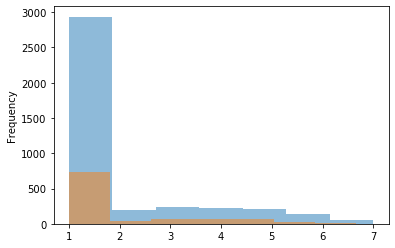

In [8]:
train_df["Information_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["Information_discrete"].plot.hist(bins=7, alpha=0.5)

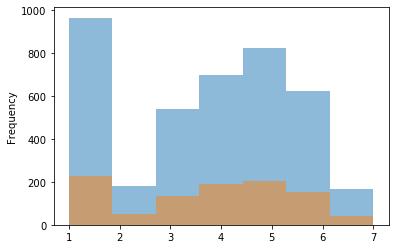

In [9]:
train_df["Thoughts_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["Thoughts_discrete"].plot.hist(bins=7, alpha=0.5)

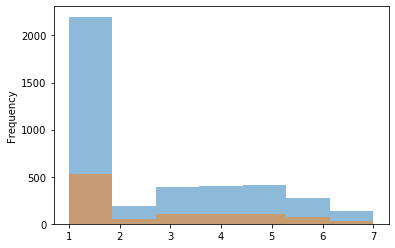

In [10]:
train_df["Feelings_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["Feelings_discrete"].plot.hist(bins=7, alpha=0.5)

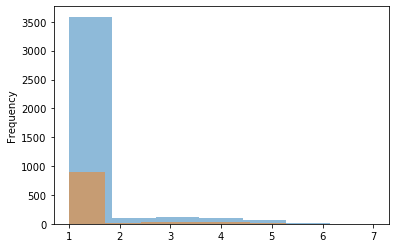

In [11]:
train_df["Intimacy_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["Intimacy_discrete"].plot.hist(bins=7, alpha=0.5)

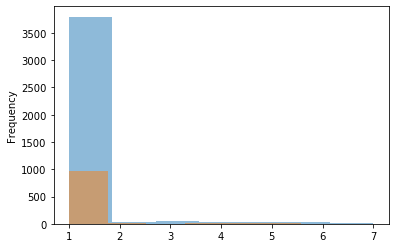

In [12]:
train_df["Relations_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["Relations_discrete"].plot.hist(bins=7, alpha=0.5)

In [18]:
train_df.head()

,TWEETID,Raw_Tweet,Cleaned_Tweet,SD,Information,Thoughts,Feelings,Intimacy,Relations,Information_discrete,Thoughts_discrete,Feelings_discrete,Intimacy_discrete,Relations_discrete,ID,Text,SD_discrete
4342,1221716646030479360,so there’s 5 confirmed cases in the us alone. ...,so there is 5 confirmed cases in the us alone....,1.866667,1.000000,4.666667,1.0,1.666667,1.000000,1.0,4.666667,1.0,1.0,1.0,1221716646030479360,so there 's 5 confirmed cases in the us alone ...,8.666667
473,1225257166577139712,And now hospitals in Wuhan only accept people ...,And now hospitals in Wuhan only accept people ...,3.600000,2.333333,6.000000,6.0,2.666667,1.000000,1.0,6.000000,6.0,1.0,1.0,1225257166577139712,and now hospitals in wuhan only accept people ...,15.000000
1224,1233798808015761408,I’m just upset with China procuring a propagan...,I am just upset with China procuring a propaga...,3.666667,1.333333,6.000000,6.0,3.666667,1.333333,1.0,6.000000,6.0,5.0,1.0,1233798808015761408,i 'm just upset with china procuring a propaga...,19.000000
3727,1266750471076810753,...so that we can continue to stop the spread ...,...so that we can continue to stop the spread ...,1.466667,1.000000,2.666667,1.0,1.666667,1.000000,1.0,3.500000,1.0,1.0,1.0,1266750471076810753,... so that we can continue to stop the spread...,7.500000
4926,1222311771601547264,Infected travelers (primarily air) are known t...,Infected travelers (primarily air) are known t...,1.400000,1.000000,2.000000,1.0,2.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1222311771601547264,infected travelers ( primarily air ) are known...,5.000000


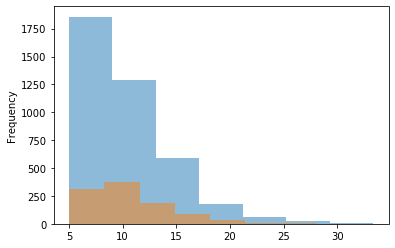

In [15]:
train_df["SD_discrete"] = train_df["Information_discrete"] + train_df["Thoughts_discrete"] + train_df["Feelings_discrete"] + train_df["Intimacy_discrete"] + train_df["Relations_discrete"]
test_df["SD_discrete"] = test_df["Information_discrete"] + test_df["Thoughts_discrete"] + test_df["Feelings_discrete"] + test_df["Intimacy_discrete"] + test_df["Relations_discrete"]

train_df["SD_discrete"].plot.hist(bins=7, alpha=0.5)
test_df["SD_discrete"].plot.hist(bins=7, alpha=0.5)

In [90]:
# from textattack.augmentation import EmbeddingAugmenter, WordNetAugmenter

In [91]:
# augmenter = EmbeddingAugmenter()
# s = 'What I cannot create, I do not understand.'
# augmenter.augment(s)

In [92]:
# augmenter = WordNetAugmenter()
# s = 'What I cannot create, I do not understand.'
# augmenter.augment(s)

In [4]:
train_df = pd.read_excel(labeled)

In [6]:
train_df['length'] = [len(tweet) for tweet in train_df['Raw_Tweet'].tolist()]
train_df.head()

,TWEETID,Raw_Tweet,Cleaned_Tweet,SD,Information,Thoughts,Feelings,Intimacy,Relations,Information_discrete,Thoughts_discrete,Feelings_discrete,Intimacy_discrete,Relations_discrete,length
0,1222474014032973824,Going back to school hope I don’t die from asi...,Going back to school hope I do not die from as...,3.266667,2.666667,6.000000,3.666667,3.000000,1.000000,3.500000,6.000000,3.666667,3.000000,1.000000,90
1,1222604569290522625,@caterpillOwO my dad visited China...,@1 my dad visited China...,2.200000,4.000000,2.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,4.000000,37
2,1221687403405930496,My cousin lives in Wuhan where the coronavirus...,My cousin lives in Wuhan where the coronavirus...,4.533333,4.333333,5.333333,4.333333,4.333333,4.333333,4.333333,5.333333,4.333333,4.333333,4.333333,93
3,1222605345937248256,Just found out she’s been evacuated! #Coronavirus,Just found out she is been evacuated! #Coronav...,2.600000,4.666667,2.666667,1.666667,1.333333,2.666667,4.666667,2.666667,1.000000,1.000000,3.500000,49
4,1222599012328456192,"before the coronavirus wipes us all out, anybo...","before the coronavirus wipes us all out, anybo...",1.800000,1.000000,3.666667,1.666667,1.666667,1.000000,1.000000,3.666667,1.000000,1.000000,1.000000,86


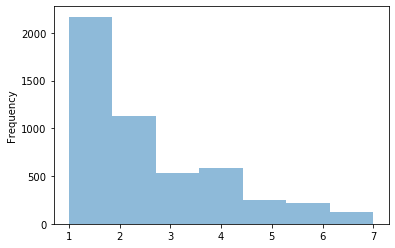

In [7]:
train_df["Feelings"].plot.hist(bins=7, alpha=0.5)

In [10]:
train_df.columns

Index(['TWEETID', 'Raw_Tweet', 'Cleaned_Tweet', 'SD', 'Information',
       'Thoughts', 'Feelings', 'Intimacy', 'Relations', 'Information_discrete',
       'Thoughts_discrete', 'Feelings_discrete', 'Intimacy_discrete',
       'Relations_discrete', 'length'],
      dtype='object')

In [8]:
import seaborn as sns

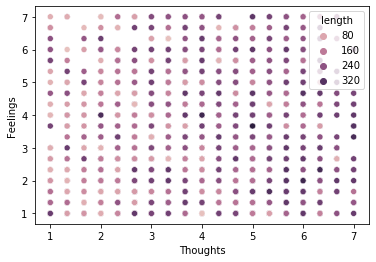

In [12]:
sns.scatterplot(data=train_df, x="Thoughts", y="Feelings", hue="length")

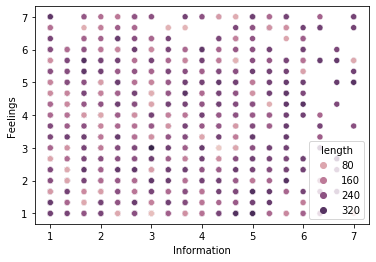

In [13]:
sns.scatterplot(data=train_df, x="Information", y="Feelings", hue="length")

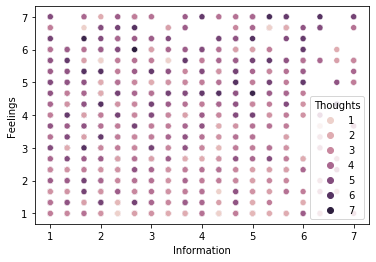

In [14]:
sns.scatterplot(data=train_df, x="Information", y="Feelings", hue="Thoughts")